In [2]:
import argparse
import torch
import torch.nn as nn
import dgl
import torch.optim as optim
from dgl.dataloading import MultiLayerFullNeighborSampler, EdgeDataLoader
from dgl.dataloading.negative_sampler import Uniform
import numpy as np
import pandas as pd
import itertools
import os
import tqdm
import matplotlib.pyplot as plt
from dgl import save_graphs, load_graphs
import dgl.function as fn
import torch.nn.functional as F
from dgl.nn.pytorch import GraphConv, SAGEConv, HeteroGraphConv
from dgl.utils import expand_as_pair
from collections import defaultdict
import torch as th
import dgl.nn as dglnn
from dgl.data.utils import makedirs, save_info, load_info
from sklearn.metrics import roc_auc_score
import gc
from thefuzz import fuzz
from thefuzz import process
import time
import re

gc.collect()

18

In [3]:
file1 = '~/Downloads/harvard-index-collectors.csv'  ## macOS file location, harvard index collector
harvard_data = pd.read_csv(file1,chunksize=10000,encoding='utf-8',on_bad_lines='skip',engine='python')
harvard_data = pd.concat(harvard_data)
harvard_columns = harvard_data.columns.tolist()
harvard_data.rename(columns={harvard_columns[8]:'labelName'}, inplace=True) ## to avoid special character in colNames

harvard_columns = harvard_data.columns.tolist()   ## load content into list
harvard_data.head()

,Unnamed: 0.1,Unnamed: 0,id,Name,First date collected,Remarks,ASA Botanist ID,GUID,labelName,Full Name,...,First date received,End Date,Specialty,URL,Last date received,Geography,Vernacular name,Image,Agent type,Team Members:
0,0,0.0,47342,"Hepp, R.",1946,[collector note: SGO],147721 botanist,http://purl.oclc.org/net/edu.harvard.huh/guid/...,R. Hepp,"Hepp, R.",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1.0,14911,"Palazzi, Andrea",NaN,[collector note: Herbarium (Piedmont (Italy): TO],114969 botanist,http://purl.oclc.org/net/edu.harvard.huh/guid/...,A. Palazzi,"Palazzi, Andrea",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2.0,29488,"Nicholls, Robert",NaN,"[collector note: BM-SL, OXF.]",129688 botanist,http://purl.oclc.org/net/edu.harvard.huh/guid/...,Robert Nicholls,"Nicholls, Robert",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,3.0,44660,"Hosie, R. C.",1937,"[collector note: Ontario, Algoma Dist., Thunde...",145012 botanist,http://purl.oclc.org/net/edu.harvard.huh/guid/...,R. C. Hosie,"Hosie, R. C.",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,4.0,10131,"Lohman, M. L.",NaN,[collector note: Type collection: FH],110149 botanist,http://purl.oclc.org/net/edu.harvard.huh/guid/...,M. L. Lohman,"Lohman, M. L.",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
file2 = '~/Downloads/wikidata-collectors-230615.csv'  ## macOS file location, wikipedia collector

wiki_data = pd.read_csv(file2,chunksize=10000,encoding='utf-8',on_bad_lines='skip',engine='python')
wiki_data = pd.concat(wiki_data)
wiki_columns = wiki_data.columns.tolist()   ## load content into list
wiki_data.head()

,id,label,institutions,dateOfBirth,ISNI,countryOfCitizenshipISO,countryOfCitizenship,aliases,bionomia,dateOfDeath,sexOrGender,VIAF,IPNI,harvardIndex,authorAbbrv,birthName
0,Q100142069,Frida Eggens,NaN,NaN,NaN,['SE'],['Q34'],['Eggens'],NaN,NaN,female,NaN,20045232-1,NaN,Eggens,NaN
1,Q100146795,Elizabeth Harrison,NaN,+1792-12-00T00:00:00Z,NaN,['GB'],"['Q161885', 'Q174193']","['Mrs Arnold Harrison', 'Mrs A. H.']",Q100146795,+1834-01-05T00:00:00Z,female,NaN,NaN,NaN,NaN,NaN
2,Q100149196,Russell Cox,['9cfe8cbf-35ff-4d93-b932-cb05d91b7922'],NaN,NaN,NaN,NaN,[],0000-0001-5149-1709,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Q100152296,Alda Pereira da Fonseca,NaN,+1882-00-00T00:00:00Z,NaN,['BR'],['Q155'],[],NaN,NaN,female,NaN,NaN,NaN,NaN,NaN
4,Q100156193,Laurence Henry Millener,['c3d8b0e8-4b2b-4692-bfa7-73117d189508'],+1914-04-01T00:00:00Z,NaN,['NZ'],['Q664'],"['L. H. Millener', 'Laurie Henry Millener', 'L...",Q100156193,+2000-00-00T00:00:00Z,male,NaN,NaN,NaN,NaN,NaN


In [19]:
wiki_data['dateOfBirth'] = convert_date2year(wiki_data,'dateOfBirth')
wiki_data['dateOfDeath'] = convert_date2year(wiki_data,'dateOfDeath')

In [20]:
harvard_data['combinedSpecialty'] = combine_specialty(harvard_data)
harvard_data['combinedGeography'] = combine_geography(harvard_data)

a, b = get_author_collector_notes(harvard_data, 'Remarks')
harvard_data['authorNotes'] = a
harvard_data['collectorNotes'] = b
harvard_data['authorNotes'] = extract_herbariums(harvard_data,'authorNotes')
harvard_data['collectorNotes'] = extract_herbariums(harvard_data,'collectorNotes')

In [21]:
cols_to_drop = ['Unnamed: 0.1','Unnamed: 0','Geography Author', 'Geography Collector', 'Geography Determiner', 
                  'Geography','Specialty Author', 'Specialty Collector', 'Specialty Determiner', 'Specialty',
                  'Remarks',]
harvard_data.drop(cols_to_drop, axis=1, inplace=True)

In [22]:
wiki_data['harvardIndex'] = pd.to_numeric(wiki_data['harvardIndex'],errors='coerce') ## wrap wiki id to int64

## Merging two dataframe
result = pd.merge(wiki_data, harvard_data, how='outer', on=None, left_on='harvardIndex', right_on='id',
                  left_index=False, right_index=False, sort=False,
                  suffixes=('_wiki', '_harvard'), copy=False, indicator=False)

name_cleaning(result)

                            sum
fullName                 152942
lastname                 152942
firstname                152942
acceptedNames            152942
id_harvard               114306
collectorNotes           114306
authorNotes              114306
combinedGeography        114306
combinedSpecialty        114306
GUID                     113019
ASA Botanist ID           87208
id_wiki                   71988
Citation as Collector     67603
IPNI                      53822
sexOrGender               50176
dateOfBirth               38647
Citation as Author        37269
Date of birth             34251
Holdings                  33528
Collections in            33528
harvardIndex              33411
First date collected      33291
dateOfDeath               27032
countryOfCitizenship      25364
VIAF                      23591
countryOfCitizenshipISO   22431
Collector Teams:          20269
Date of death             17862
ISNI                      17629
Agent type                15425
Team Mem

<AxesSubplot:title={'center':'Merged Data'}>

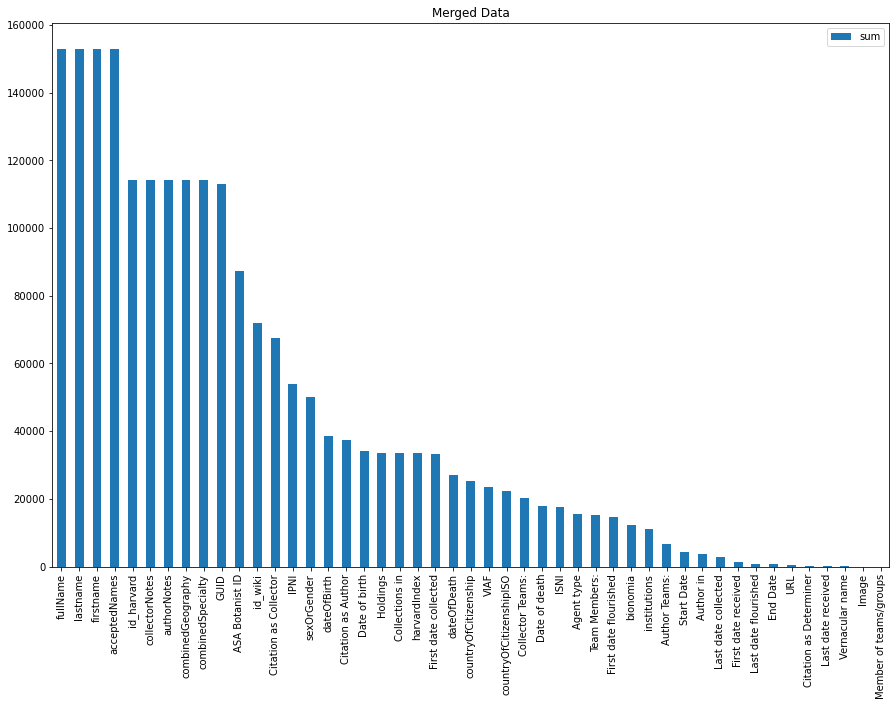

In [23]:
distribution = get_distribution(result, result.columns.tolist())
temp = distribution.T.sort_values(by=['sum'], ascending=False)
print(temp)
temp.plot.bar(figsize=(15,10), title = 'Merged Data')

In [24]:
result

,id_wiki,institutions,dateOfBirth,ISNI,countryOfCitizenshipISO,countryOfCitizenship,bionomia,dateOfDeath,sexOrGender,VIAF,...,Agent type,Team Members:,combinedSpecialty,combinedGeography,authorNotes,collectorNotes,acceptedNames,firstname,lastname,fullName
0,Q100142069,NaN,NaN,NaN,['SE'],['Q34'],NaN,NaN,female,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"Eggens,Frida Eggens,Eggens",Frida,Eggens,Frida Eggens
1,Q100146795,NaN,1792.0,NaN,['GB'],"['Q161885', 'Q174193']",Q100146795,1834.0,female,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"Mrs Arnold Harrison, Mrs A. H.,Elizabeth Harrison",Elizabeth,Harrison,Elizabeth Harrison
2,Q100149196,['9cfe8cbf-35ff-4d93-b932-cb05d91b7922'],NaN,NaN,NaN,NaN,0000-0001-5149-1709,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,",Russell Cox",Russell,Cox,Russell Cox
3,Q100152296,NaN,1882.0,NaN,['BR'],['Q155'],NaN,NaN,female,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,",Alda Pereira da Fonseca",Alda,Fonseca,Alda Fonseca
4,Q100156193,['c3d8b0e8-4b2b-4692-bfa7-73117d189508'],1914.0,NaN,['NZ'],['Q664'],Q100156193,2000.0,male,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"L. H. Millener, Laurie Henry Millener, Laurie ...",Laurence,Millener,Laurence Millener
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152937,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Team/Group,"Takeuchi, Wayne N.Mogea, Johanis P.",{Spermatophytes},{Indonesia},[],[],"Takeuchi, Wayne N. & Mogea, Johanis P., Takeuc...",J. P.,Takeuchi,J. P.'] ['Takeuchi
152938,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Team/Group,"Canne-Hilliker, Judith M.Hruschak, Kathleen A.",{Spermatophytes},{United States of America},[],[],"Canne-Hilliker, Judith M. & Hruschak, Kathleen...",K. A.,Canne-Hilliker,K. A.'] ['Canne-Hilliker
152939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Team/Group,"Hesler, Lexemuel RayPorter, J. P.Sharp, Aaron ...",{Fungi},{United States of America},[],[TN],"Sharp, Aaron John, Porter, J. P. & Hesler, Lex...",Lexemuel Ray,Sharp,Lexemuel Ray Sharp
152940,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Team/Group,"Ama, DemasTakeuchi, Wayne N.Gamui, B",{Spermatophytes},{Papua New Guinea},[],[],"Takeuchi, Wayne N., Ama, Demas & Gamui, B, Tak...",B.,Takeuchi,B.'] ['Takeuchi


In [5]:
# Method to compute and plot the data distribution of a given dataframe
'''
Example:
distribution = get_distribution(wiki_data, wiki_columns)
temp = distribution.T.sort_values(by=['sum'], ascending=False)
print(temp)
temp.plot.bar(figsize=(15,10), title = 'WikiData')
'''
def get_distribution(data, col):
    sum_count = 0
    data_distribution = {} ## a dictionary to store the distribution of individual entity
    data_distribution_sum = pd.DataFrame(columns = col, index=['sum'])
    for (columnName, columnData) in data.iteritems():
        temp = data[columnName].value_counts()
        data_distribution_sum.at['sum', columnName]=sum(temp)
    return data_distribution_sum

In [6]:
'''
# this function will remove all special charaters -- including spaces
# used process_time() for evaluation
Example:
newCol = remove_spec_in_col(wiki_data,'aliases')
'''
# Remove square blankets auto generated during data alignment process
def clean_text(text): # fb
    text = text.replace('[', '').replace(']','').replace("'", '')
    return text

def remove_spec_in_col(df, col):
    newCol = []
    for index, rowValue in df[col].iteritems():
        if pd.notnull(rowValue):
            newCol.append(clean_text(rowValue))
        else:
            newCol.append(np.nan)
    return newCol


In [7]:
# Replace empty list as np.nan
def remove_empty(df, col):
    newCol = []
    for index, rowValue in df[col].iteritems():
        if not rowValue:
            newCol.append(np.nan)
        else:
            newCol.append(rowValue)
    return newCol

In [8]:
'''
For Harvard Index data preprocessing
Example:
text1 = "[author note: Types at: MT] [collector note: col. with M. St-Arnaud; MT; BO]"
text2 = "[collector note: Herbarium (Piedmont (Italy): TO]"
text3 = "[collector note: SAFB] plant pathologist; short biography and photo: Can. J. Plant Pathol. Vol. 28: S21-S22. 2006."
text4 = "[collector note: BM-SL, OXF.]"
text5 = "[collector note: Herbarium and types, US, additional m,erial , B, C, DBN, GH, K, MIN, MO, NA, NY, PH"
text = "[author note: LE; temperate Asian Polygonaceae] [collector note: LE] "
temp = text4.split("[")

s1 = get_author_notes(temp)
s2 = get_collector_notes(temp)
print("\nFunction version:")
print("author note: ", s1)
for i in s1: print("\nHerbarium List: ", get_herbarium_codes(i))
print("collector note: ", s2)
for i in s2: print("\nHerbarium List: ", get_herbarium_codes(i))

a, b = get_author_collector_notes(harvard_data, 'Remarks')

b = harvard_data[['id', 'collector note']].copy()
b['collector note'] = extract_herbariums(b,'collector note')
'''
            
def get_author_notes(string):
    authorNotes = []
    for s in string:
        # s = clean_text(s)
        # authorNotes.append(s.partition("author note: ")[2].partition(" ")[0].replace(";", ''))
        authorNotes.append(s.partition("author note: ")[2].partition("]")[0].replace(";", ',').replace(":", ',').replace("(",",").replace(")",",").replace("at",","))
    authorNotes = list(filter(None, authorNotes))
    return authorNotes

def get_collector_notes(string):
    collectorNotes = []
    for s in string:
        # s = clean_text(s)
        # collectorNotes.append(s.partition("collector note: ")[2].partition(" ")[0].replace(";", ''))
        collectorNotes.append(s.partition("collector note: ")[2].partition("]")[0].replace(";", ',').replace(":", ',').replace("(",",").replace(")",",").replace("at",","))
    collectorNotes = list(filter(None, collectorNotes))
    return collectorNotes

def get_author_collector_notes(df, col):
    authorNoteCol = []
    collectorNoteCol = []
    for index, rowValue in df[col].iteritems():
        if pd.notnull(rowValue):
            string = rowValue.split("[")
            authorNoteCol.append(get_author_notes(string))
            collectorNoteCol.append(get_collector_notes(string))
        else:
            authorNoteCol.append([]) # use empty to reduce runtime exception while condition checking
            collectorNoteCol.append([])
    return authorNoteCol, collectorNoteCol

# Functions to extract the herbarium institution codes from Remarks in Harvard Index
def get_herbarium_codes(string):
    herbarium_codes = []
    for s in string.split(","):
        if s.isupper():
            herbarium_codes.append(re.sub('[^A-Z]', ',', s).replace(",",""))
    return herbarium_codes

def extract_herbariums(df, col):
    newCol = []
    for index, rowValue in df[col].iteritems():
        if rowValue:
            temp = []
            for i in rowValue: 
                temp += get_herbarium_codes(i)
            newCol.append(temp)
        else:
            newCol.append([])
    return newCol

In [9]:
'''
Return the cleaned year value of Wikidata
Example:
new_df['dateOfBirthYear'] = convert_date2year(wiki_data,'dateOfBirth')
'''
def get_year(date_str):
    # Remove + sign
    if date_str[0] == '+':
        date_str = date_str[1:]
    return int(date_str[0:4])

def convert_date2year(df, col):
    newCol = []
    for index, rowValue in df[col].iteritems():
        if pd.notnull(rowValue):
            newCol.append(get_year(rowValue))
        else:
            newCol.append(np.NaN)
    return newCol

# Not used in the data cleaning process
def get_timestamp(date_str):
    # Probably not necessary
    date_str = date_str.strip()
    # Remove + sign
    if date_str[0] == '+':
        date_str = date_str[1:]
    # Remove missing month/day
    date_str = date_str.split('-00', maxsplit=1)[0]
    # Parse date
    dt = np.datetime64(date_str)
    # As Unix timestamp (choose preferred datetype)
    return dt.astype('<M8[s]').astype(np.int64)

In [10]:
'''
For Harvard Index data preprocessing
Example:
temp = harvard_data[['id','Name','Specialty Author', 'Specialty Collector', 'Specialty Determiner', 'Specialty']].copy()
temp['combine_specialty'] = combine_specialty(temp)
# temp['combine_specialty'].value_counts().index.tolist()
'''
# Extract specialty areas of collectors
def combine_specialty(df):
    cols = ['Specialty Author', 'Specialty Collector', 'Specialty Determiner', 'Specialty']
    newCol = df[cols].apply(lambda row: ','.join(row.dropna().unique()), axis=1)
    for index, rowValue in newCol.iteritems():
        if pd.notnull(rowValue):
            newCol[index] = set(clean_text(rowValue).replace('And',',').replace(' and ',',').replace(' ','').split(','))
        else:
            newCol[index] = np.nan
    return newCol

In [11]:
'''
For Harvard Index data preprocessing
Example:
temp = harvard_data[['id','Name','Geography Author', 'Geography Collector', 'Geography Determiner', 'Geography']].copy()
temp['combine_geography'] = combine_geography(temp)
# temp['combine_geography'].value_counts().index.tolist()
'''
# Extract geography locations and travel history related to collectors
def combine_geography(df):
    cols = ['Geography Author', 'Geography Collector', 'Geography Determiner', 'Geography']
    newCol = df[cols].apply(lambda row: ','.join(row.dropna().unique()), axis=1)
    for index, rowValue in newCol.iteritems():
        if pd.notnull(rowValue):
            newCol[index] = set(clean_text(rowValue).replace('\xa0 ','').split(','))
        else:
            newCol[index] = np.nan
    return newCol

In [12]:
'''
For Combining Wikidata and Harvard Index data
Example:
wiki_data['harvardIndex'] = return_numeric(wiki_data, 'harvardIndex')

# But it's the same as the below inbuilt function
wiki_data['harvardIndex'] = pd.to_numeric(wiki_data['harvardIndex'],errors='coerce') ## wrap wiki id to int64
'''
# Helper function to extract numerical numbers from a data column
def return_numeric(df, col):
    newCol = []
    for index, rowValue in df[col].iteritems():
        if pd.notnull(rowValue):
            newCol.append(re.sub("[^0-9|.]", "", str(rowValue)))
        else:
            newCol.append(rowValue)
    return newCol

In [13]:
'''
import unicodedata as ud

latin_letters= {}

def is_latin(uchr):
    try: return latin_letters[uchr]
    except KeyError:
         return latin_letters.setdefault(uchr, 'LATIN' in ud.name(uchr))

def only_roman_chars(unistr):
    return all(is_latin(uchr)
           for uchr in unistr
           if uchr.isalpha()) 
           
Example:
clean_encode_characters_col(df,'Name')
clean_encode_characters(df)
'''
#Clean the latin encoded characters - This is so silly...but it works
def clean_encode_characters(df): # clean all the dataframe
    df = df.replace(to_replace ="Ã¶", value ="ö", regex=True) 
    df = df.replace(to_replace ="Ã©", value ="é", regex=True)
    df = df.replace(to_replace ="Ã¨", value ="è", regex=True)
    df = df.replace(to_replace ="Ã¼", value ="ü", regex=True)
    
def clean_encode_characters_col(df,col): # clean specific column of the dataframe
    df[col] = df[col].replace(to_replace ="Ã¶", value ="ö", regex=True) 
    df[col] = df[col].replace(to_replace ="Ã©", value ="é", regex=True)
    df[col] = df[col].replace(to_replace ="Ã¨", value ="è", regex=True)
    df[col] = df[col].replace(to_replace ="Ã¼", value ="ü", regex=True)

In [14]:
## Helper function to check config in name list
def remove_name_config(nameList):
    i = 0
    while i < len(nameList):
        j = i + 1
        while j < len(nameList):
            if fuzz.token_set_ratio(nameList[i], nameList[j]) == 100:
                del nameList[j]
            else:
                j += 1
        i += 1
    return nameList

In [15]:
# function to get firstnames and lastnames from wiki
def get_firstname_lastname_wiki(df):
    colName = 'label'
    df['firstnames_wiki'] = df[colName].str.split('\s+').str[0]
    df['lastnames_wiki'] = df[colName].str.split('\s+').str[-1]

# function to get firstnames and lastnames from harvard
def get_firstname_lastname_harvard(df):
    colName = 'Name'
    df['firstnames_harvard'] = df[colName].str.split(', ').str[-1]
    df['lastnames_harvard'] = df[colName].str.split(', ').str[0]
    
# function to get firstnames 
def get_firstname(df):
    firstNameList = []
    temp = []
    colNames = ['firstnames_wiki','firstnames_harvard']
    firstNameList = df[colNames].apply(lambda row: ','.join(row.dropna().unique()), axis=1)
    for index, rowValue in firstNameList.iteritems():
        temp = rowValue.split(',')
        if isinstance(temp, str):
            firstNameList[index] = rowValue
        else:
            temp = remove_name_config(temp)
            firstNameList[index] = temp[0]
    return firstNameList

# function to get lastnames
def get_lastname(df):
    lastNameList = []
    temp = []
    colNames = ['lastnames_wiki','lastnames_harvard'] # add the columns you wanna combine here
    lastNameList = df[colNames].apply(lambda row: ','.join(row.dropna().unique()), axis=1)
    for index, rowValue in lastNameList.iteritems():
        temp = rowValue.split(',')
        if isinstance(temp, str):
            lastNameList[index] = rowValue
        else:
            temp = remove_name_config(temp)
            lastNameList[index] = temp[0]
    return lastNameList

# function to return all possible author abbreviations
def get_authorAbbrv(df):
    newCol = []
    temp = []
    colNames = ['authorAbbrv','B\xa0&\xa0P\xa0Author\xa0Abbrev.'] # add the columns you wanna combine here
    newCol = df[colNames].apply(lambda row: ','.join(row.dropna().unique()), axis=1)
    for index, rowValue in newCol.iteritems():
        temp = rowValue.split(',')
        if isinstance(temp, str):
            newCol[index] = rowValue
        else:
            temp = remove_name_config(temp)
            newCol[index] = temp
    return newCol

# function to return the collector's fullname
def get_fullName(df):
    newCol = []
    colNames_w = ['firstnames_wiki','lastnames_wiki']
    colNames_h = ['firstnames_harvard','lastnames_harvard']
    fullname_w = df[colNames_w].apply(lambda row: ' '.join(row.dropna().unique()), axis=1)
    fullname_h = df[colNames_h].apply(lambda row: ' '.join(row.dropna().unique()), axis=1)
    newCol = fullname_w
    for index, rowValue in fullname_w.iteritems():
        if len(rowValue) > len(fullname_h[index]):
            newCol[index] = rowValue
        else:
            newCol[index] = fullname_h[index]
    return newCol

In [17]:
# Extract specialty areas of collectors - for Harvard Index data preprocessing
def combine_name_list(df):
    nameList = []
    cols_name_to_combine = ['aliases','label','authorAbbrv','birthName',
                            'Name','labelName','Full Name','Variant name','Author name'
                            ,'B\xa0&\xa0P\xa0Author\xa0Abbrev.']
    nameList = df[cols_name_to_combine].apply(lambda row: ','.join(row.dropna().unique()), axis=1)
    return nameList

def drop_dump_names(df):
    cols_to_drop = ['aliases','label','authorAbbrv','birthName','Variant name',
                    'Name','labelName','Full Name','Author name','B\xa0&\xa0P\xa0Author\xa0Abbrev.',
                   'firstnames_wiki','lastnames_wiki','firstnames_harvard','lastnames_harvard']

    df.drop(cols_to_drop, axis=1, inplace=True)

In [18]:
# collector name cleaning process
def name_cleaning(df):
    
    result['acceptedNames'] = combine_name_list(result) # return all accepted names of a collector
    result['acceptedNames'] = remove_spec_in_col(result,'acceptedNames')
    
    get_firstname_lastname_wiki(df)
    get_firstname_lastname_harvard(df)
    df['firstname'] = get_firstname(df)
    df['lastname'] = get_lastname(df)
    df['firstname'] = remove_spec_in_col(df,'firstname') # return firstname of a collector
    df['lastname'] = remove_spec_in_col(df,'lastname') # return lastname of a collector
    
    df['authorAbbrv'] = get_authorAbbrv(df) # return all possible author abbreviations of a collector
    
    df['fullName'] = get_fullName(df)
    df['fullName'] = remove_spec_in_col(df,'fullName') # return fullname of a collector
    
    clean_encode_characters_col(df,'firstname')
    clean_encode_characters_col(df,'lastname')
    clean_encode_characters_col(df,'fullName')
    
    drop_dump_names(df)